Risk Stratification

Requirements:
Develop a model to stratify patients according to their risk of contracting/developing certain conditions. The choice of condition is entirely upto you. You could choose to stratify patients according to their risk of developing heart attacks, diabetes etc. Report which features are of interest to your chosen pathology. Also report which features strongly predict the different risk classes, for instance certain features could strongly predict higher risk categories, but weakly predict lower risk, while other features could better predict the lower risk categories. 



In this project, I choose  diabetes, which I would predict patients' risk of developing gestational diabetes. I would also like to explore the different risk classes, and how they are related to each other.


Part I  Data preprocessing and Data cleaning

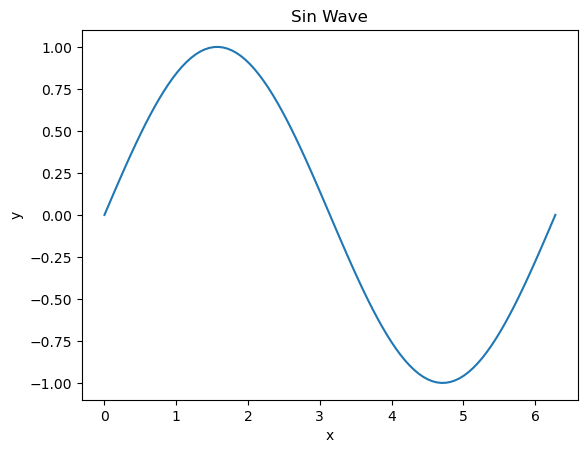

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# test
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# draw
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sin Wave')
plt.show()


In [2]:
#import the data
mimic_path='/Users/jieche/Desktop/machine learning/mimic-iv-2.2/'

In [4]:
#Begin with admission data
admits = pd.read_csv(mimic_path + 'hosp/admissions.csv.gz', compression='gzip')
admits.head()


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [5]:
#Only keep the useful information for analysis.
admits = admits[['subject_id','hadm_id', 'race']]
admits.head()


,subject_id,hadm_id,race
0,10000032,22595853,WHITE
1,10000032,22841357,WHITE
2,10000032,25742920,WHITE
3,10000032,29079034,WHITE
4,10000068,25022803,WHITE


In [6]:
#Simplify the data
admits['race'].value_counts()


WHITE                                        272932
BLACK/AFRICAN AMERICAN                        59959
OTHER                                         15102
UNKNOWN                                       10668
HISPANIC/LATINO - PUERTO RICAN                 8076
WHITE - OTHER EUROPEAN                         7925
HISPANIC OR LATINO                             7754
ASIAN                                          6156
ASIAN - CHINESE                                5587
WHITE - RUSSIAN                                5024
BLACK/CAPE VERDEAN                             4765
HISPANIC/LATINO - DOMINICAN                    4383
BLACK/CARIBBEAN ISLAND                         2704
BLACK/AFRICAN                                  2530
PATIENT DECLINED TO ANSWER                     1761
UNABLE TO OBTAIN                               1603
PORTUGUESE                                     1510
ASIAN - SOUTH EAST ASIAN                       1446
HISPANIC/LATINO - GUATEMALAN                   1330
ASIAN - ASIA

In [7]:
import re

# 将所有以"white"开头的字符串替换为"white"
admits['race'] = admits['race'].apply(
    lambda x: re.sub(r'^WHITE.*', 'WHITE', str(x)))
admits['race'] = admits['race'].apply(
    lambda x: re.sub(r'^BLACK.*', 'BLACK', str(x)))
admits['race'] = admits['race'].apply(
    lambda x: re.sub(r'^ASIAN.*', 'ASIAN', str(x)))
admits['race'] = admits['race'].apply(
    lambda x: re.sub(r'^HISPANIC.*', 'HISPANIC', str(x)))
admits['race'].value_counts()


WHITE                                        288154
BLACK                                         69958
HISPANIC                                      25212
OTHER                                         15102
ASIAN                                         14893
UNKNOWN                                       10668
PATIENT DECLINED TO ANSWER                     1761
UNABLE TO OBTAIN                               1603
PORTUGUESE                                     1510
AMERICAN INDIAN/ALASKA NATIVE                   919
MULTIPLE RACE/ETHNICITY                         560
SOUTH AMERICAN                                  505
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       386
Name: race, dtype: int64

In [8]:
# put the others in the same category: other/unknown
admits['race'].loc[~admits['race'].isin(
    admits['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
admits['race'].value_counts()


/var/folders/ck/8r_z2td51y379bxk8krf4ss00000gn/T/ipykernel_42836/2112628393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admits['race'].loc[~admits['race'].isin(


WHITE            288154
BLACK             69958
HISPANIC          25212
OTHER/UNKNOWN     17912
OTHER             15102
ASIAN             14893
Name: race, dtype: int64

In [9]:
# combine other and other/unknown
admits['race'].replace(
    ['OTHER/UNKNOWN', 'OTHER'], value='OTHER/UNKNOWN', inplace=True)
admits['race'].value_counts()


WHITE            288154
BLACK             69958
OTHER/UNKNOWN     33014
HISPANIC          25212
ASIAN             14893
Name: race, dtype: int64

In [10]:
# patient
patients = pd.read_csv(mimic_path + 'hosp/patients.csv.gz', compression='gzip')
patients.head()


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


In [11]:
#only keep the women between 18-65
# 只保留女性
patients = patients[patients['gender'] == 'F']

# 只保留年龄在18-65岁之间的患者
patients = patients[(patients['anchor_age'] >= 18) &
                    (patients['anchor_age'] <= 65)]

# 重置索引
patients = patients.reset_index(drop=True)

# 输出结果
patients.head()


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000102,F,27,2136,2008 - 2010,NaN
4,10000117,F,48,2174,2008 - 2010,NaN


In [12]:
#Only keep id, gender, and age
patients = patients[['subject_id','anchor_age']]
patients.head()


,subject_id,anchor_age
0,10000032,52
1,10000048,23
2,10000068,19
3,10000102,27
4,10000117,48


In [13]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119710 entries, 0 to 119709
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   subject_id  119710 non-null  int64
 1   anchor_age  119710 non-null  int64
dtypes: int64(2)
memory usage: 1.8 MB


In [15]:
patients.anchor_age.describe()


count    119710.000000
mean         38.397878
std          14.485048
min          18.000000
25%          25.000000
50%          36.000000
75%          52.000000
max          65.000000
Name: anchor_age, dtype: float64

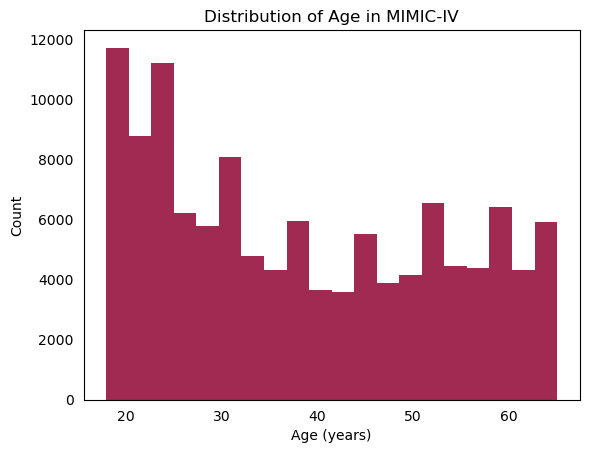

In [16]:
plt.hist(patients['anchor_age'], bins=20, color='#a12a52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show()


In [17]:
age_ranges = [(18, 30), (31, 40), (41, 50), (51, 65)]
for num, cat_range in enumerate(age_ranges):
    patients['anchor_age'] = np.where(patients['anchor_age'].between(
        cat_range[0], cat_range[1]), num, patients['anchor_age'])

age_dict = {0: 'YOUNG_ADULT', 1: 'MIDDLE_ADULT', 2: 'OLD_ADULT', 3: 'SENIOR'}
patients['anchor_age'] = patients['anchor_age'].replace(age_dict)
patients.anchor_age.value_counts()


YOUNG_ADULT     46440
SENIOR          32068
MIDDLE_ADULT    22266
OLD_ADULT       18936
Name: anchor_age, dtype: int64

In [18]:
# merge patients and admisssions(according to the description, subject id is the identification of patients, while hadm id is the event number, here use the subject id)
admits_patients = pd.merge(admits, patients, how='inner', on='subject_id')
admits_patients.head()


,subject_id,hadm_id,race,anchor_age
0,10000032,22595853,WHITE,SENIOR
1,10000032,22841357,WHITE,SENIOR
2,10000032,25742920,WHITE,SENIOR
3,10000032,29079034,WHITE,SENIOR
4,10000068,25022803,WHITE,YOUNG_ADULT


In [19]:
admits_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144141 entries, 0 to 144140
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   subject_id  144141 non-null  int64 
 1   hadm_id     144141 non-null  int64 
 2   race        144141 non-null  object
 3   anchor_age  144141 non-null  object
dtypes: int64(2), object(2)
memory usage: 5.5+ MB


In [23]:
# read diagnoses_icd table
icds = pd.read_csv(mimic_path + 'hosp/diagnoses_icd.csv.gz',
                   compression='gzip')

icds.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [21]:
icds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 181.4+ MB


In [24]:
print(icds.shape[0])
print(icds.icd_code.nunique())
print(icds.subject_id.nunique())


4756326
25809
180640


In [25]:
group_icd_codes = True
if group_icd_codes:
    icds["icd_code"] = icds["icd_code"].apply(lambda x: str(x)[:8])


In [26]:
icds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 181.4+ MB


In [30]:
gd_patients = icds[icds['icd_code'].str.contains('O244|648')]

num_gdpatients = gd_patients.shape[0]

print("There are", num_gdpatients, "diagnoses of Gestational diabetes.")


There are 13542 diagnoses of Gestational diabetes.


In [37]:
icds['GD'] = 0


# 在 GD 列中标记为 1
icds.loc[icds['subject_id'].isin(gd_patients), 'GD'] = 1


In [39]:
icds.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,GD,diabete_history,pregnant_time
0,10000032,22595853,1,5723,9,0,0,0
1,10000032,22595853,2,78959,9,0,0,0
2,10000032,22595853,3,5715,9,0,0,0
3,10000032,22595853,4,07070,9,0,0,0
4,10000032,22595853,5,496,9,0,0,0


In [38]:
icds.GD.value_counts()



0    4423811
1     332515
Name: GD, dtype: int64

In [47]:
#find patients that suffers diabetes before gestational diabetes
# 先将diabete_history设置为0
icds['diabete_history'] = 0

# 根据subject_id进行分组，对每个分组进行操作
for _, group in icds.groupby('subject_id'):
    gd_diagnoses = group[group['icd_code'].str.contains('O244|648')]
    if not gd_diagnoses.empty:
        first_gd_index = gd_diagnoses.index[0]
        before_gd_diagnoses = group.loc[:first_gd_index-1]
        if before_gd_diagnoses[before_gd_diagnoses['icd_code'].str.contains('250|E08|E09|E10|E11|E12|E13')].shape[0] > 0:
            icds.loc[before_gd_diagnoses.index, 'diabete_history'] = 1


In [48]:
icds.diabete_history.value_counts()


0    4705239
1      51087
Name: diabete_history, dtype: int64

In [49]:




# 只保留 GD、diabete_history 和 pregnant_time 三列
diagnoses = icds[['subject_id', 'hadm_id','icd_code','GD', 'diabete_history']]


In [50]:
diagnoses.head()

,subject_id,hadm_id,icd_code,GD,diabete_history
0,10000032,22595853,5723,0,0
1,10000032,22595853,78959,0,0
2,10000032,22595853,5715,0,0
3,10000032,22595853,07070,0,0
4,10000032,22595853,496,0,0


In [51]:
diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   subject_id       int64 
 1   hadm_id          int64 
 2   icd_code         object
 3   GD               int64 
 4   diabete_history  int64 
dtypes: int64(4), object(1)
memory usage: 181.4+ MB


Change the icd10 code to icd9, as I had done in the project of readmission prediction. I have the csv file which contains the transferred file. And read it directly.

In [53]:
diag_icds = pd.read_csv('diag_icds_transfer.csv')

diag_icds.columns = diag_icds.iloc[0]
diag_icds = diag_icds.iloc[1:].reset_index(drop=True)

diag_icds.head()


/var/folders/ck/8r_z2td51y379bxk8krf4ss00000gn/T/ipykernel_42836/2406960701.py:1: DtypeWarning: Columns (0,1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  diag_icds = pd.read_csv('diag_icds_transfer.csv')


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [54]:
diag_icds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   object
 1   hadm_id      object
 2   seq_num      object
 3   icd_code     object
 4   icd_version  object
dtypes: object(5)
memory usage: 181.4+ MB


In [55]:
# The code is stored as object, change the datatype to int64
diag_icds['subject_id'] = diag_icds['subject_id'].astype('int64')
diag_icds['hadm_id'] = diag_icds['hadm_id'].astype('int64')
diag_icds['seq_num'] = diag_icds['seq_num'].astype('int64')
diag_icds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  object
dtypes: int64(3), object(2)
memory usage: 181.4+ MB


In [56]:
# Filter out E and V codes from ICD9 codes since processing will be done on the numeric first 3 values
diag_icds['recode'] = diag_icds['icd_code']
diag_icds['recode'] = diag_icds['recode'][~diag_icds['recode'].str.contains(
    "[a-zA-Z]").fillna(False)]
diag_icds['recode'].fillna(value='999', inplace=True)

# Take in consideration just the first 3 integers of the ICD9 code
diag_icds['recode'] = diag_icds['recode'].str.slice(start=0, stop=3, step=1)
diag_icds['recode'] = diag_icds['recode'].astype(int)
diag_icds.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version,recode
0,10000032,22595853,1,5723,9,572
1,10000032,22595853,2,78959,9,789
2,10000032,22595853,3,5715,9,571
3,10000032,22595853,4,07070,9,70
4,10000032,22595853,5,496,9,496


In [57]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580,
                                                    630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    diag_icds['recode'] = np.where(diag_icds['recode'].between(
        cat_range[0], cat_range[1]), num, diag_icds['recode'])

# Convert integer to category name using diag_dict
diag_icds['super_category'] = diag_icds['recode'].replace(diag_dict)
diag_icds.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version,recode,super_category
0,10000032,22595853,1,5723,9,8,digestive
1,10000032,22595853,2,78959,9,15,misc
2,10000032,22595853,3,5715,9,8,digestive
3,10000032,22595853,4,07070,9,0,infectious
4,10000032,22595853,5,496,9,7,respiratory


In [58]:
# Create list of diagnoses for each admission
hadm_list = diag_icds.groupby(
    'hadm_id')['super_category'].apply(list).reset_index()
hadm_list.head()


,hadm_id,super_category
0,20000019,"[infectious, genitourinary, congenital, genito..."
1,20000024,"[injury, injury, injury, injury, injury, injur..."
2,20000034,"[injury, injury, injury, injury, injury, injur..."
3,20000041,"[muscular, endocrine, injury, circulatory, end..."
4,20000057,"[muscular, muscular, injury, injury, injury, r..."


In [59]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(
    hadm_list['super_category'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()


/var/folders/ck/8r_z2td51y379bxk8krf4ss00000gn/T/ipykernel_42836/1190710123.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  hadm_item = pd.get_dummies(


,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,1,1,1,0,3,2,1,2,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0
3,0,1,0,1,3,0,0,4,0,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,7,0,1,5,0,4,0,1,2,0


In [60]:
# Join back with HADM_ID
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")


In [62]:
#store as csv file
hadm_item.to_csv('hadm_item.csv', index=False)


In [63]:
#merge with diagnoses
diag_df = pd.merge(diagnoses, hadm_item, on='hadm_id', how='inner')


In [64]:
diag_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4756326 entries, 0 to 4756325
Data columns (total 22 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   subject_id       int64 
 1   hadm_id          int64 
 2   icd_code         object
 3   GD               int64 
 4   diabete_history  int64 
 5   blood            uint8 
 6   circulatory      uint8 
 7   congenital       uint8 
 8   digestive        uint8 
 9   endocrine        uint8 
 10  genitourinary    uint8 
 11  infectious       uint8 
 12  injury           uint8 
 13  mental           uint8 
 14  misc             uint8 
 15  muscular         uint8 
 16  neoplasms        uint8 
 17  nervous          uint8 
 18  pregnancy        uint8 
 19  prenatal         uint8 
 20  respiratory      uint8 
 21  skin             uint8 
dtypes: int64(4), object(1), uint8(17)
memory usage: 294.8+ MB


In [65]:
diag_df.head()


,subject_id,hadm_id,icd_code,GD,diabete_history,blood,circulatory,congenital,digestive,endocrine,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,10000032,22595853,5723,0,0,0,0,0,2,0,...,1,2,1,0,0,0,0,0,1,0
1,10000032,22595853,78959,0,0,0,0,0,2,0,...,1,2,1,0,0,0,0,0,1,0
2,10000032,22595853,5715,0,0,0,0,0,2,0,...,1,2,1,0,0,0,0,0,1,0
3,10000032,22595853,07070,0,0,0,0,0,2,0,...,1,2,1,0,0,0,0,0,1,0
4,10000032,22595853,496,0,0,0,0,0,2,0,...,1,2,1,0,0,0,0,0,1,0


In [70]:
# merge icds with patients and admisssions(according to the description, subject id is the identification of patients, while hadm id is the event number, here use the subject id)
admits_patients_diag = pd.merge(admits_patients, diag_df, on='hadm_id', how='inner')
admits_patients_diag = admits_patients_diag.drop(columns=['subject_id_y', 'icd_code'])
admits_patients_diag = admits_patients_diag.rename(
    columns={'subject_id_x': 'subject_id'})


admits_patients_diag.head()


,subject_id,hadm_id,race,anchor_age,GD,diabete_history,blood,circulatory,congenital,digestive,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,2,...,1,2,1,0,0,0,0,0,1,0
1,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,2,...,1,2,1,0,0,0,0,0,1,0
2,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,2,...,1,2,1,0,0,0,0,0,1,0
3,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,2,...,1,2,1,0,0,0,0,0,1,0
4,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,2,...,1,2,1,0,0,0,0,0,1,0


In [71]:
admits_patients_diag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1320142 entries, 0 to 1320141
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   subject_id       1320142 non-null  int64 
 1   hadm_id          1320142 non-null  int64 
 2   race             1320142 non-null  object
 3   anchor_age       1320142 non-null  object
 4   GD               1320142 non-null  int64 
 5   diabete_history  1320142 non-null  int64 
 6   blood            1320142 non-null  uint8 
 7   circulatory      1320142 non-null  uint8 
 8   congenital       1320142 non-null  uint8 
 9   digestive        1320142 non-null  uint8 
 10  endocrine        1320142 non-null  uint8 
 11  genitourinary    1320142 non-null  uint8 
 12  infectious       1320142 non-null  uint8 
 13  injury           1320142 non-null  uint8 
 14  mental           1320142 non-null  uint8 
 15  misc             1320142 non-null  uint8 
 16  muscular         1320142 non-null  u

In [72]:
count_subjects = admits_patients_diag['subject_id'].nunique()
print(f"Number of unique subjects: {count_subjects}")


Number of unique subjects: 62653


Continue with omr

In [73]:
omr = pd.read_csv(mimic_path + 'hosp/omr.csv.gz', compression='gzip')
omr.head()



,subject_id,chartdate,seq_num,result_name,result_value
0,10000032,2180-04-27,1,Blood Pressure,110/65
1,10000032,2180-04-27,1,Weight (Lbs),94
2,10000032,2180-05-07,1,BMI (kg/m2),18.0
3,10000032,2180-05-07,1,Height (Inches),60
4,10000032,2180-05-07,1,Weight (Lbs),92.15


In [74]:
omr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6439169 entries, 0 to 6439168
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   subject_id    int64 
 1   chartdate     object
 2   seq_num       int64 
 3   result_name   object
 4   result_value  object
dtypes: int64(2), object(3)
memory usage: 245.6+ MB


In [75]:
omr.result_name.value_counts()


Blood Pressure                      2169549
Weight (Lbs)                        1889542
BMI (kg/m2)                         1662112
Height (Inches)                      706906
Blood Pressure Sitting                 3400
Blood Pressure Lying                   2764
Blood Pressure Standing (1 min)        2560
Blood Pressure Standing (3 mins)        626
BMI                                     554
Blood Pressure Standing                 523
Weight                                  354
eGFR                                    240
Height                                   39
Name: result_name, dtype: int64

In [76]:
omr.result_value.value_counts()


64        44170
66        41355
65        41325
63        39441
67        37919
          ...  
223.20        1
432.9         1
113/03        1
228.90        1
66.53         1
Name: result_value, Length: 24846, dtype: int64

In [79]:
# I need blood pressure and BMI here.
# filter for desired result names
# Extract blood pressure and BMI results
bp_results = omr[omr['result_name'] == 'Blood Pressure']
bmi_results = omr[omr['result_name'] == 'BMI (kg/m2)']

# Pivot results to wide format
bp_results = bp_results.pivot_table(
    values='result_value', index='subject_id', columns='result_name', aggfunc='first')
bmi_results = bmi_results.pivot_table(
    values='result_value', index='subject_id', columns='result_name', aggfunc='first')

# Merge results into one dataframe
bp_bmi_results = pd.concat([bp_results, bmi_results], axis=1)

# drop NaN values
bp_bmi_results.dropna(inplace=True)

# Split blood pressure column into systolic and diastolic pressure columns
bp_bmi_results[['Systolic_BP', 'Diastolic_BP']
               ] = bp_bmi_results['Blood Pressure'].str.split('/', expand=True)

# Convert systolic and diastolic pressure columns to numeric
bp_bmi_results['Systolic_BP'] = pd.to_numeric(bp_bmi_results['Systolic_BP'])
bp_bmi_results['Diastolic_BP'] = pd.to_numeric(bp_bmi_results['Diastolic_BP'])

bp_bmi_results = bp_bmi_results.rename(columns={'BMI (kg/m2)': 'BMI'})


# Convert BMI column to numeric
bp_bmi_results['BMI'] = pd.to_numeric(bp_bmi_results['BMI'])

# Add subject_id as a column
bp_bmi_results = bp_bmi_results.reset_index()





In [81]:
bp_bmi_results=bp_bmi_results[['subject_id', 'BMI', 'Systolic_BP', 'Diastolic_BP']]

bp_bmi_results.head()


result_name,subject_id,BMI,Systolic_BP,Diastolic_BP
0,10000032,18.0,110,65
1,10000117,19.6,124,66
2,10000635,31.7,140,86
3,10000719,37.0,144,88
4,10000826,20.5,88,58


In [82]:
bp_bmi_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115523 entries, 0 to 115522
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   subject_id    115523 non-null  int64  
 1   BMI           115523 non-null  float64
 2   Systolic_BP   115523 non-null  int64  
 3   Diastolic_BP  115523 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.5 MB


In [83]:
admits_patients_diag_omr = pd.merge(admits_patients_diag, bp_bmi_results, on='subject_id', how='inner')


In [84]:
admits_patients_diag_omr.head()

,subject_id,hadm_id,race,anchor_age,GD,diabete_history,blood,circulatory,congenital,digestive,...,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,BMI,Systolic_BP,Diastolic_BP
0,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,2,...,0,0,0,0,0,1,0,18.0,110,65
1,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,2,...,0,0,0,0,0,1,0,18.0,110,65
2,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,2,...,0,0,0,0,0,1,0,18.0,110,65
3,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,2,...,0,0,0,0,0,1,0,18.0,110,65
4,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,2,...,0,0,0,0,0,1,0,18.0,110,65


In [87]:
admits_patients_diag_omr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990663 entries, 0 to 990662
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   subject_id       990663 non-null  int64  
 1   hadm_id          990663 non-null  int64  
 2   race             990663 non-null  object 
 3   anchor_age       990663 non-null  object 
 4   GD               990663 non-null  int64  
 5   diabete_history  990663 non-null  int64  
 6   blood            990663 non-null  uint8  
 7   circulatory      990663 non-null  uint8  
 8   congenital       990663 non-null  uint8  
 9   digestive        990663 non-null  uint8  
 10  endocrine        990663 non-null  uint8  
 11  genitourinary    990663 non-null  uint8  
 12  infectious       990663 non-null  uint8  
 13  injury           990663 non-null  uint8  
 14  mental           990663 non-null  uint8  
 15  misc             990663 non-null  uint8  
 16  muscular         990663 non-null  uint

In [88]:
admits_patients_diag_omr.to_csv('admits_patients_diag_omr.csv')


In [2]:
admits_patients_diag_omr =pd.read_csv('admits_patients_diag_omr.csv')


labevents is a large file, I deal with it in chunks: labevents_processing.ipynb


In [3]:
#labevents
lab_result = pd.read_csv('lab_results_pivot.csv')
lab_result.head()



,subject_id,Glucose,Hemoglobin A1c,HDL,LDL,Creatinine,Triglycerides,Urea Nitrogen,Uric Acid
0,10000032,NaN,NaN,52.000000,135.000000,0.466667,73.000000,30.388889,NaN
1,10000048,NaN,NaN,NaN,NaN,0.700000,NaN,16.000000,NaN
2,10000084,NaN,NaN,NaN,NaN,0.733333,NaN,12.666667,NaN
3,10000108,NaN,NaN,NaN,NaN,1.000000,NaN,12.000000,NaN
4,10000117,NaN,5.3,71.142857,154.285714,0.868750,90.857143,10.066667,NaN


In [5]:
lab_result.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242288 entries, 0 to 242287
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   subject_id      242288 non-null  int64  
 1   Glucose         46609 non-null   float64
 2   Hemoglobin A1c  74715 non-null   float64
 3   HDL             82375 non-null   float64
 4   LDL             78437 non-null   float64
 5   Creatinine      239831 non-null  float64
 6   Triglycerides   84508 non-null   float64
 7   Urea Nitrogen   237983 non-null  float64
 8   Uric Acid       23723 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 16.6 MB


In [4]:
final_df=pd.merge(admits_patients_diag_omr, lab_result, on='subject_id', how='inner')
final_df.head()



,Unnamed: 0,subject_id,hadm_id,race,anchor_age,GD,diabete_history,blood,circulatory,congenital,...,Systolic_BP,Diastolic_BP,Glucose,Hemoglobin A1c,HDL,LDL,Creatinine,Triglycerides,Urea Nitrogen,Uric Acid
0,0,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,...,110,65,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN
1,1,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,...,110,65,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN
2,2,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,...,110,65,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN
3,3,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,...,110,65,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN
4,4,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,...,110,65,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN


In [27]:
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 984014 entries, 0 to 984013
Data columns (total 35 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       984014 non-null  int64  
 1   subject_id       984014 non-null  int64  
 2   hadm_id          984014 non-null  int64  
 3   race             984014 non-null  object 
 4   anchor_age       984014 non-null  object 
 5   GD               984014 non-null  int64  
 6   diabete_history  984014 non-null  int64  
 7   blood            984014 non-null  int64  
 8   circulatory      984014 non-null  int64  
 9   congenital       984014 non-null  int64  
 10  digestive        984014 non-null  int64  
 11  endocrine        984014 non-null  int64  
 12  genitourinary    984014 non-null  int64  
 13  infectious       984014 non-null  int64  
 14  injury           984014 non-null  int64  
 15  mental           984014 non-null  int64  
 16  misc             984014 non-null  int6

In [30]:
adm_pat_dia_omr_lab = pd.merge(admits_patients_diag_omr, lab_result, on='subject_id', how='inner')


In [31]:
adm_pat_dia_omr_lab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984014 entries, 0 to 984013
Data columns (total 35 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       984014 non-null  int64  
 1   subject_id       984014 non-null  int64  
 2   hadm_id          984014 non-null  int64  
 3   race             984014 non-null  object 
 4   anchor_age       984014 non-null  object 
 5   GD               984014 non-null  int64  
 6   diabete_history  984014 non-null  int64  
 7   blood            984014 non-null  int64  
 8   circulatory      984014 non-null  int64  
 9   congenital       984014 non-null  int64  
 10  digestive        984014 non-null  int64  
 11  endocrine        984014 non-null  int64  
 12  genitourinary    984014 non-null  int64  
 13  infectious       984014 non-null  int64  
 14  injury           984014 non-null  int64  
 15  mental           984014 non-null  int64  
 16  misc             984014 non-null  int6

In [32]:
adm_pat_dia_omr_lab.to_csv('adm_pat_dia_omr_lab.csv')


Go with prescriptions

In [33]:
prescriptions = pd.read_csv(
    mimic_path+'hosp/prescriptions.csv.gz', compression='gzip', usecols=['subject_id', 'hadm_id','drug'])
prescriptions.head()

,subject_id,hadm_id,drug
0,10000032,22595853,Acetaminophen
1,10000032,22595853,Sodium Chloride 0.9% Flush
2,10000032,22595853,Furosemide
3,10000032,22595853,Raltegravir
4,10000032,22595853,Heparin


In [34]:

prescriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15416708 entries, 0 to 15416707
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   subject_id  int64 
 1   hadm_id     int64 
 2   drug        object
dtypes: int64(2), object(1)
memory usage: 352.9+ MB


In [35]:
num_missing = prescriptions['drug'].isna().sum()
print('总共有 {} 个缺失值。'.format(num_missing))


总共有 1 个缺失值。


In [36]:

missing_values = prescriptions[prescriptions['drug'].isna()]

print(missing_values)


          subject_id   hadm_id drug
15333304    19945152  26408801  NaN


In [38]:
prescriptions = prescriptions.dropna(subset=['drug'])


In [39]:
prescriptions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15416707 entries, 0 to 15416707
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   subject_id  int64 
 1   hadm_id     int64 
 2   drug        object
dtypes: int64(2), object(1)
memory usage: 470.5+ MB


In [12]:
num_missing = prescriptions['drug'].isna().sum()
print('总共有 {} 个缺失值。'.format(num_missing))


总共有 0 个缺失值。


In [40]:
prescriptions['insulin'] = 0
prescriptions['insulin'] = prescriptions['drug'].str.contains(
    'insulin', case=False).astype(int)



In [41]:
prescriptions.head()


,subject_id,hadm_id,drug,insulin
0,10000032,22595853,Acetaminophen,0
1,10000032,22595853,Sodium Chloride 0.9% Flush,0
2,10000032,22595853,Furosemide,0
3,10000032,22595853,Raltegravir,0
4,10000032,22595853,Heparin,0


In [42]:
prescriptions.insulin.value_counts()


0    14784146
1      632561
Name: insulin, dtype: int64

In [45]:
insulin_data = prescriptions[prescriptions['insulin'] == 1]
subject_id_count = insulin_data['subject_id'].nunique()
hadm_id_count = insulin_data['hadm_id'].nunique()
print(f"Number of unique subject_ids with insulin=1: {subject_id_count}")
print(f"Number of unique hadm_ids with insulin=1: {hadm_id_count}")


Number of unique subject_ids with insulin=1: 56209
Number of unique hadm_ids with insulin=1: 117125


In [15]:
pres=prescriptions[['hadm_id','insulin']]
pres.head()

,hadm_id,insulin
0,22595853,0
1,22595853,0
2,22595853,0
3,22595853,0
4,22595853,0


In [16]:
pres.to_csv('prescriptions.csv')


In [7]:
pres=pd.read_csv('prescriptions.csv')


In [8]:
#merge with final
final_df = pd.merge(final_df, pres, on='hadm_id', how='inner')
final_df.head()

,Unnamed: 0_x,subject_id,hadm_id,race,anchor_age,GD,diabete_history,blood,circulatory,congenital,...,Glucose,Hemoglobin A1c,HDL,LDL,Creatinine,Triglycerides,Urea Nitrogen,Uric Acid,Unnamed: 0_y,insulin
0,0,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,...,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN,0,0
1,0,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,...,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN,1,0
2,0,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,...,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN,2,0
3,0,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,...,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN,3,0
4,0,10000032,22595853,WHITE,SENIOR,0,0,0,0,0,...,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN,4,0


In [9]:
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 47978633 entries, 0 to 47978632
Data columns (total 37 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0_x     int64  
 1   subject_id       int64  
 2   hadm_id          int64  
 3   race             object 
 4   anchor_age       object 
 5   GD               int64  
 6   diabete_history  int64  
 7   blood            int64  
 8   circulatory      int64  
 9   congenital       int64  
 10  digestive        int64  
 11  endocrine        int64  
 12  genitourinary    int64  
 13  infectious       int64  
 14  injury           int64  
 15  mental           int64  
 16  misc             int64  
 17  muscular         int64  
 18  neoplasms        int64  
 19  nervous          int64  
 20  pregnancy        int64  
 21  prenatal         int64  
 22  respiratory      int64  
 23  skin             int64  
 24  BMI              float64
 25  Systolic_BP      int64  
 26  Diastolic_BP     int64  
 27  Glucose   

In [10]:
final_df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 47978633 entries, 0 to 47978632
Data columns (total 35 columns):
 #   Column           Dtype  
---  ------           -----  
 0   subject_id       int64  
 1   hadm_id          int64  
 2   race             object 
 3   anchor_age       object 
 4   GD               int64  
 5   diabete_history  int64  
 6   blood            int64  
 7   circulatory      int64  
 8   congenital       int64  
 9   digestive        int64  
 10  endocrine        int64  
 11  genitourinary    int64  
 12  infectious       int64  
 13  injury           int64  
 14  mental           int64  
 15  misc             int64  
 16  muscular         int64  
 17  neoplasms        int64  
 18  nervous          int64  
 19  pregnancy        int64  
 20  prenatal         int64  
 21  respiratory      int64  
 22  skin             int64  
 23  BMI              float64
 24  Systolic_BP      int64  
 25  Diastolic_BP     int64  
 26  Glucose          float64
 27  Hemoglobin

Here the final_df is too big for me to deal with, I tried to keep the insulin result, but my computer cannot handle it. As a result,adm_pat_dia_omr_lab will be the final_df instead.

In [3]:
final_df= pd.read_csv('adm_pat_dia_omr_lab.csv')

In [4]:
final_df.head()

,Unnamed: 0.1,Unnamed: 0,subject_id,hadm_id,race,anchor_age,GD,diabete_history,blood,circulatory,...,Systolic_BP,Diastolic_BP,Glucose,Hemoglobin A1c,HDL,LDL,Creatinine,Triglycerides,Urea Nitrogen,Uric Acid
0,0,0,10000032,22595853,WHITE,SENIOR,0,0,0,0,...,110,65,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN
1,1,1,10000032,22595853,WHITE,SENIOR,0,0,0,0,...,110,65,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN
2,2,2,10000032,22595853,WHITE,SENIOR,0,0,0,0,...,110,65,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN
3,3,3,10000032,22595853,WHITE,SENIOR,0,0,0,0,...,110,65,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN
4,4,4,10000032,22595853,WHITE,SENIOR,0,0,0,0,...,110,65,NaN,NaN,52.0,135.0,0.466667,73.0,30.388889,NaN


In [5]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984014 entries, 0 to 984013
Data columns (total 36 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0.1     984014 non-null  int64  
 1   Unnamed: 0       984014 non-null  int64  
 2   subject_id       984014 non-null  int64  
 3   hadm_id          984014 non-null  int64  
 4   race             984014 non-null  object 
 5   anchor_age       984014 non-null  object 
 6   GD               984014 non-null  int64  
 7   diabete_history  984014 non-null  int64  
 8   blood            984014 non-null  int64  
 9   circulatory      984014 non-null  int64  
 10  congenital       984014 non-null  int64  
 11  digestive        984014 non-null  int64  
 12  endocrine        984014 non-null  int64  
 13  genitourinary    984014 non-null  int64  
 14  infectious       984014 non-null  int64  
 15  injury           984014 non-null  int64  
 16  mental           984014 non-null  int6

In [6]:
final_df.GD.value_counts()

0    846851
1    137163
Name: GD, dtype: int64

Data Cleaning

In [7]:
# Drop unused or no longer needed columns
final_df.drop(columns=['subject_id', 'hadm_id','Unnamed: 0.1','Unnamed: 0'], inplace=True)

final_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984014 entries, 0 to 984013
Data columns (total 32 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   race             984014 non-null  object 
 1   anchor_age       984014 non-null  object 
 2   GD               984014 non-null  int64  
 3   diabete_history  984014 non-null  int64  
 4   blood            984014 non-null  int64  
 5   circulatory      984014 non-null  int64  
 6   congenital       984014 non-null  int64  
 7   digestive        984014 non-null  int64  
 8   endocrine        984014 non-null  int64  
 9   genitourinary    984014 non-null  int64  
 10  infectious       984014 non-null  int64  
 11  injury           984014 non-null  int64  
 12  mental           984014 non-null  int64  
 13  misc             984014 non-null  int64  
 14  muscular         984014 non-null  int64  
 15  neoplasms        984014 non-null  int64  
 16  nervous          984014 non-null  int6

In [8]:
final_df.isnull().sum()


race                    0
anchor_age              0
GD                      0
diabete_history         0
blood                   0
circulatory             0
congenital              0
digestive               0
endocrine               0
genitourinary           0
infectious              0
injury                  0
mental                  0
misc                    0
muscular                0
neoplasms               0
nervous                 0
pregnancy               0
prenatal                0
respiratory             0
skin                    0
BMI                     0
Systolic_BP             0
Diastolic_BP            0
Glucose            536686
Hemoglobin A1c     345600
HDL                347363
LDL                366378
Creatinine           1998
Triglycerides      307150
Urea Nitrogen        5846
Uric Acid          635551
dtype: int64

In [9]:
final_df['Uric Acid'].count()


348463

Number of missing values is 635551, much more than the existed value,  fill in this value may lead to bias, drop the rows with missing values could be a better choice.



In [10]:
final_df.drop(columns=['Uric Acid'], inplace=True)
final_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984014 entries, 0 to 984013
Data columns (total 31 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   race             984014 non-null  object 
 1   anchor_age       984014 non-null  object 
 2   GD               984014 non-null  int64  
 3   diabete_history  984014 non-null  int64  
 4   blood            984014 non-null  int64  
 5   circulatory      984014 non-null  int64  
 6   congenital       984014 non-null  int64  
 7   digestive        984014 non-null  int64  
 8   endocrine        984014 non-null  int64  
 9   genitourinary    984014 non-null  int64  
 10  infectious       984014 non-null  int64  
 11  injury           984014 non-null  int64  
 12  mental           984014 non-null  int64  
 13  misc             984014 non-null  int64  
 14  muscular         984014 non-null  int64  
 15  neoplasms        984014 non-null  int64  
 16  nervous          984014 non-null  int6

In [12]:
final_df['Glucose'].count()

447328

In [13]:
# Considering I'm focusing on gestational diabetes, the glucose level is very important. Drop rows that glucose value is NaN
final_df = final_df.dropna(subset=['Glucose'])
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 447328 entries, 61 to 984013
Data columns (total 31 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   race             447328 non-null  object 
 1   anchor_age       447328 non-null  object 
 2   GD               447328 non-null  int64  
 3   diabete_history  447328 non-null  int64  
 4   blood            447328 non-null  int64  
 5   circulatory      447328 non-null  int64  
 6   congenital       447328 non-null  int64  
 7   digestive        447328 non-null  int64  
 8   endocrine        447328 non-null  int64  
 9   genitourinary    447328 non-null  int64  
 10  infectious       447328 non-null  int64  
 11  injury           447328 non-null  int64  
 12  mental           447328 non-null  int64  
 13  misc             447328 non-null  int64  
 14  muscular         447328 non-null  int64  
 15  neoplasms        447328 non-null  int64  
 16  nervous          447328 non-null  int

In [14]:
final_df.isnull().sum()


race                    0
anchor_age              0
GD                      0
diabete_history         0
blood                   0
circulatory             0
congenital              0
digestive               0
endocrine               0
genitourinary           0
infectious              0
injury                  0
mental                  0
misc                    0
muscular                0
neoplasms               0
nervous                 0
pregnancy               0
prenatal                0
respiratory             0
skin                    0
BMI                     0
Systolic_BP             0
Diastolic_BP            0
Glucose                 0
Hemoglobin A1c      98388
HDL                115823
LDL                123467
Creatinine             63
Triglycerides       91879
Urea Nitrogen          58
dtype: int64

In [15]:
# Create dummy columns for categorical variables
prefix_cols = ['RACE', 'AGE']
dummy_cols = ['race', 'anchor_age']
final_df = pd.get_dummies(final_df, prefix=prefix_cols, columns=dummy_cols)
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 447328 entries, 61 to 984013
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   GD                  447328 non-null  int64  
 1   diabete_history     447328 non-null  int64  
 2   blood               447328 non-null  int64  
 3   circulatory         447328 non-null  int64  
 4   congenital          447328 non-null  int64  
 5   digestive           447328 non-null  int64  
 6   endocrine           447328 non-null  int64  
 7   genitourinary       447328 non-null  int64  
 8   infectious          447328 non-null  int64  
 9   injury              447328 non-null  int64  
 10  mental              447328 non-null  int64  
 11  misc                447328 non-null  int64  
 12  muscular            447328 non-null  int64  
 13  neoplasms           447328 non-null  int64  
 14  nervous             447328 non-null  int64  
 15  pregnancy           447328 non-nu

In [16]:
# The missing values of Creatinine and Urea Nitrogen are very small, just drop the rows with their missing values.
final_df = final_df.dropna(subset=['Creatinine'])
final_df = final_df.dropna(subset=['Urea Nitrogen'])
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 447254 entries, 61 to 984013
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   GD                  447254 non-null  int64  
 1   diabete_history     447254 non-null  int64  
 2   blood               447254 non-null  int64  
 3   circulatory         447254 non-null  int64  
 4   congenital          447254 non-null  int64  
 5   digestive           447254 non-null  int64  
 6   endocrine           447254 non-null  int64  
 7   genitourinary       447254 non-null  int64  
 8   infectious          447254 non-null  int64  
 9   injury              447254 non-null  int64  
 10  mental              447254 non-null  int64  
 11  misc                447254 non-null  int64  
 12  muscular            447254 non-null  int64  
 13  neoplasms           447254 non-null  int64  
 14  nervous             447254 non-null  int64  
 15  pregnancy           447254 non-nu

In [17]:
final_df.isnull().sum()


GD                         0
diabete_history            0
blood                      0
circulatory                0
congenital                 0
digestive                  0
endocrine                  0
genitourinary              0
infectious                 0
injury                     0
mental                     0
misc                       0
muscular                   0
neoplasms                  0
nervous                    0
pregnancy                  0
prenatal                   0
respiratory                0
skin                       0
BMI                        0
Systolic_BP                0
Diastolic_BP               0
Glucose                    0
Hemoglobin A1c         98325
HDL                   115774
LDL                   123418
Creatinine                 0
Triglycerides          91830
Urea Nitrogen              0
RACE_ASIAN                 0
RACE_BLACK                 0
RACE_HISPANIC              0
RACE_OTHER/UNKNOWN         0
RACE_WHITE                 0
AGE_MIDDLE_ADU

Missing data, which were common in the databases, would introduce bias to subsequent analysis ; to avoid introducing this bias, I excluded covariates with > 40% missing data and patients with > 20% missing covariates.

In [18]:
# 计算每个变量的缺失率
var_missing = final_df.isnull().sum() / len(final_df)
# 选取缺失率小于40%的变量
selected_vars = var_missing[var_missing < 0.4].index
# 保留选中的变量
final_df = final_df[selected_vars]


In [19]:
# 计算每个患者的缺失率
patient_missing = final_df.isnull().sum(axis=1) / len(final_df.columns)
# 选取缺失率小于20%的患者
selected_patients = patient_missing[patient_missing < 0.2].index
# 保留选中的患者
final_df = final_df.loc[selected_patients, :]


In [20]:
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 447254 entries, 61 to 984013
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   GD                  447254 non-null  int64  
 1   diabete_history     447254 non-null  int64  
 2   blood               447254 non-null  int64  
 3   circulatory         447254 non-null  int64  
 4   congenital          447254 non-null  int64  
 5   digestive           447254 non-null  int64  
 6   endocrine           447254 non-null  int64  
 7   genitourinary       447254 non-null  int64  
 8   infectious          447254 non-null  int64  
 9   injury              447254 non-null  int64  
 10  mental              447254 non-null  int64  
 11  misc                447254 non-null  int64  
 12  muscular            447254 non-null  int64  
 13  neoplasms           447254 non-null  int64  
 14  nervous             447254 non-null  int64  
 15  pregnancy           447254 non-nu

In [21]:
final_df.isnull().sum()

GD                         0
diabete_history            0
blood                      0
circulatory                0
congenital                 0
digestive                  0
endocrine                  0
genitourinary              0
infectious                 0
injury                     0
mental                     0
misc                       0
muscular                   0
neoplasms                  0
nervous                    0
pregnancy                  0
prenatal                   0
respiratory                0
skin                       0
BMI                        0
Systolic_BP                0
Diastolic_BP               0
Glucose                    0
Hemoglobin A1c         98325
HDL                   115774
LDL                   123418
Creatinine                 0
Triglycerides          91830
Urea Nitrogen              0
RACE_ASIAN                 0
RACE_BLACK                 0
RACE_HISPANIC              0
RACE_OTHER/UNKNOWN         0
RACE_WHITE                 0
AGE_MIDDLE_ADU

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
variables = ['BMI','Systolic_BP','Diastolic_BP','Glucose','Hemoglobin A1c','HDL','LDL','Creatinine','Triglycerides',
             'Urea Nitrogen']
#check the outliers

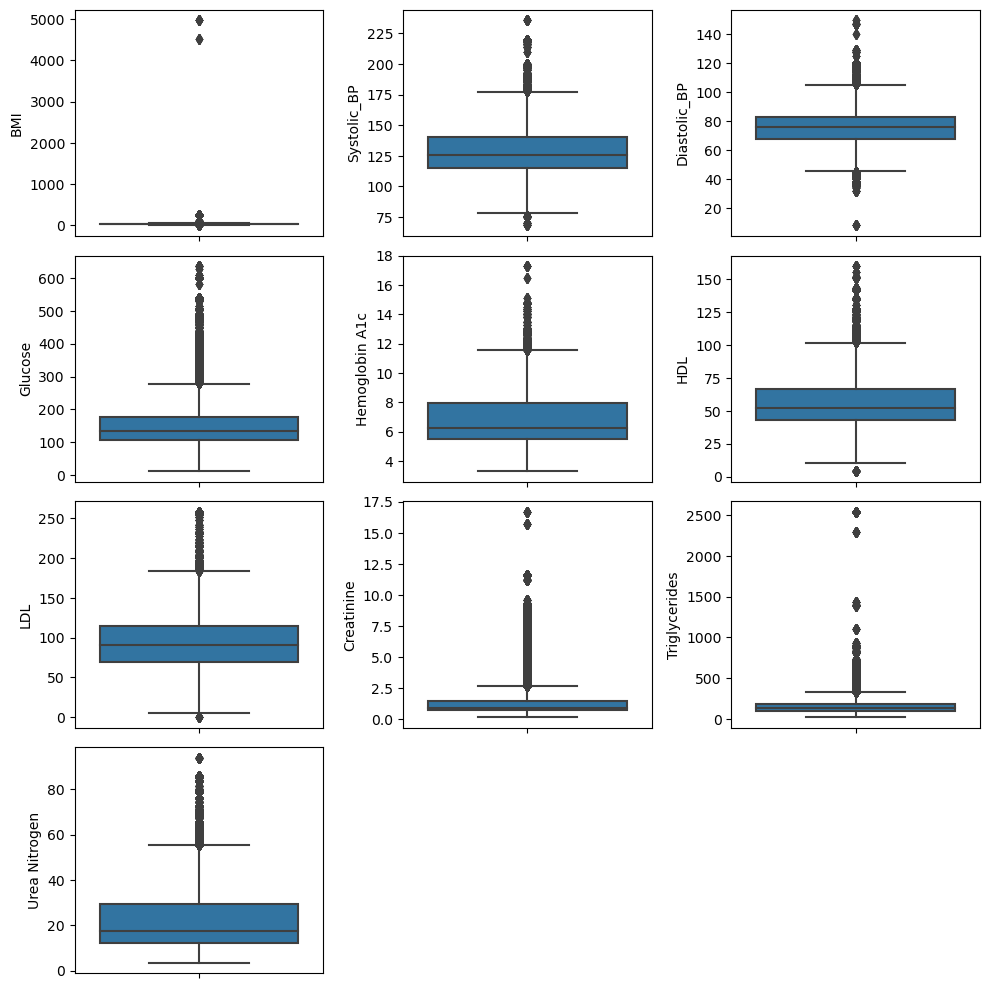

In [24]:
import seaborn as sns

fig = plt.figure(figsize=(10, 10))
count = 0
for variable in variables:
    count += 1
    plt.subplot(4, 3, count)
    ax = sns.boxplot(y=variable, data=final_df)

fig.tight_layout()
plt.show()


Ideally, we should keep extreme values related to the patients' poor health condition and exclude impossible values (such as negative temperature) and probable outliers (such as heart rate above 250 beats/min). In order to do so, values that fall outside boundaries defined by expert knowledge are excluded. This way, we avoid excluding extreme (but correct/possible) values.

In [25]:
nulls_before = final_df.isnull().sum().sum()

final_df.loc[final_df['BMI'] > 300, 'BMI'] = np.nan
final_df.loc[final_df['Diastolic_BP'] > 300, 'Diastolic_BP'] = np.nan
final_df.loc[final_df['Systolic_BP'] > 10000,  'Systolic_BP'] = np.nan
final_df.loc[final_df['Glucose'] > 2000, 'Glucose'] = np.nan
final_df.loc[final_df['Hemoglobin A1c'] > 20, 'Hemoglobin A1c'] = np.nan
final_df.loc[final_df['HDL'] > 300, 'HDL'] = np.nan
final_df.loc[final_df['LDL'] > 300, 'LDL'] = np.nan
final_df.loc[final_df['Creatinine'] > 400, 'Creatinine'] = np.nan
final_df.loc[final_df['Triglycerides'] > 5000, 'Triglycerides'] = np.nan
final_df.loc[final_df['Urea Nitrogen'] > 200, 'Urea Nitrogen'] = np.nan


nulls_now = final_df.isnull().sum().sum()
print('Number of observations removed: ' + str(nulls_now - nulls_before))


Number of observations removed: 21


In [26]:
print('Observations corresponding to outliers: ' + str(round((nulls_now - nulls_before)*100/final_df.shape[0],2)) + '%')

Observations corresponding to outliers: 0.0%


In [27]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447254 entries, 61 to 984013
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   GD                  447254 non-null  int64  
 1   diabete_history     447254 non-null  int64  
 2   blood               447254 non-null  int64  
 3   circulatory         447254 non-null  int64  
 4   congenital          447254 non-null  int64  
 5   digestive           447254 non-null  int64  
 6   endocrine           447254 non-null  int64  
 7   genitourinary       447254 non-null  int64  
 8   infectious          447254 non-null  int64  
 9   injury              447254 non-null  int64  
 10  mental              447254 non-null  int64  
 11  misc                447254 non-null  int64  
 12  muscular            447254 non-null  int64  
 13  neoplasms           447254 non-null  int64  
 14  nervous             447254 non-null  int64  
 15  pregnancy           447254 non-nu

Now check the result after dealing with extreme values

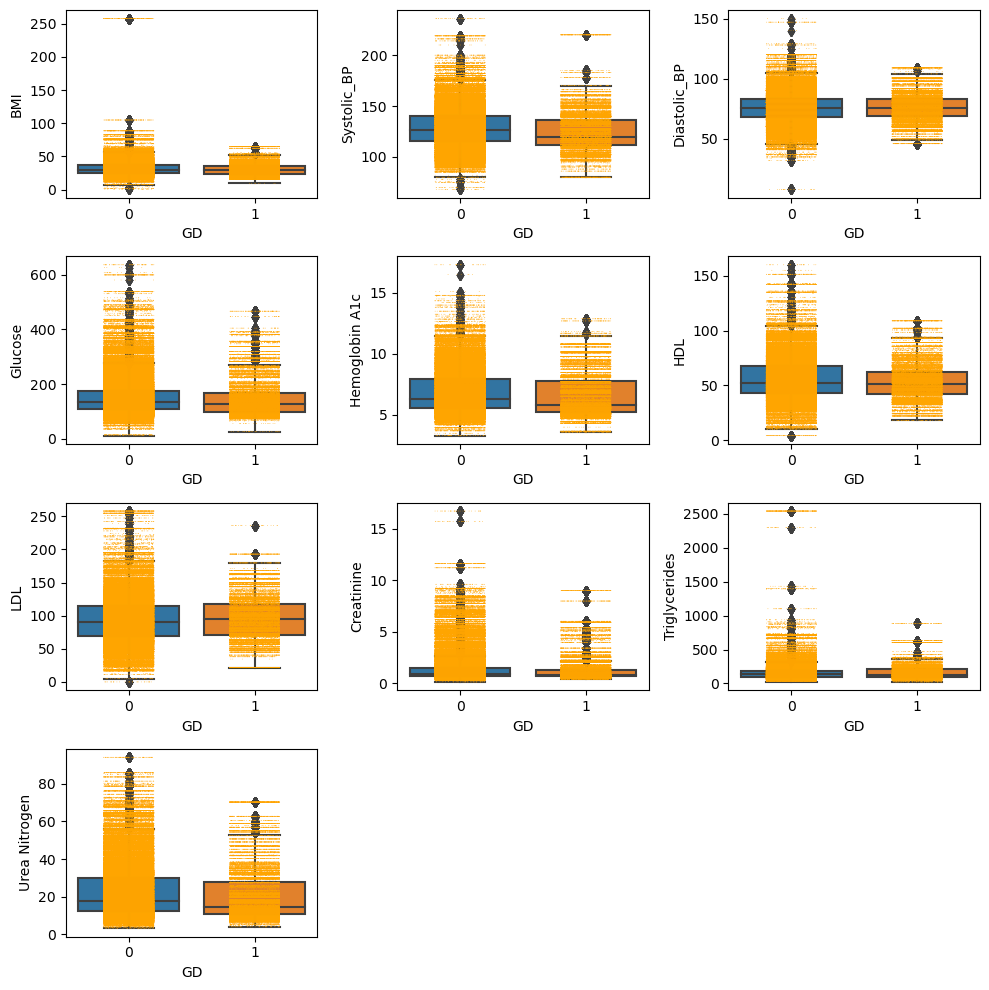

In [28]:
fig = plt.figure(figsize=(10, 10))
count = 0
for variable in variables:
    count += 1
    plt.subplot(4, 3, count)

    ax = sns.boxplot(x='GD', y=variable, data=final_df)
    ax = sns.stripplot(x='GD', y=variable, data=final_df,color="orange", jitter=0.2, size=0.5)

fig.tight_layout()
plt.show()


In [29]:
final_df.loc[final_df['BMI'] > 200, 'BMI'] = np.nan


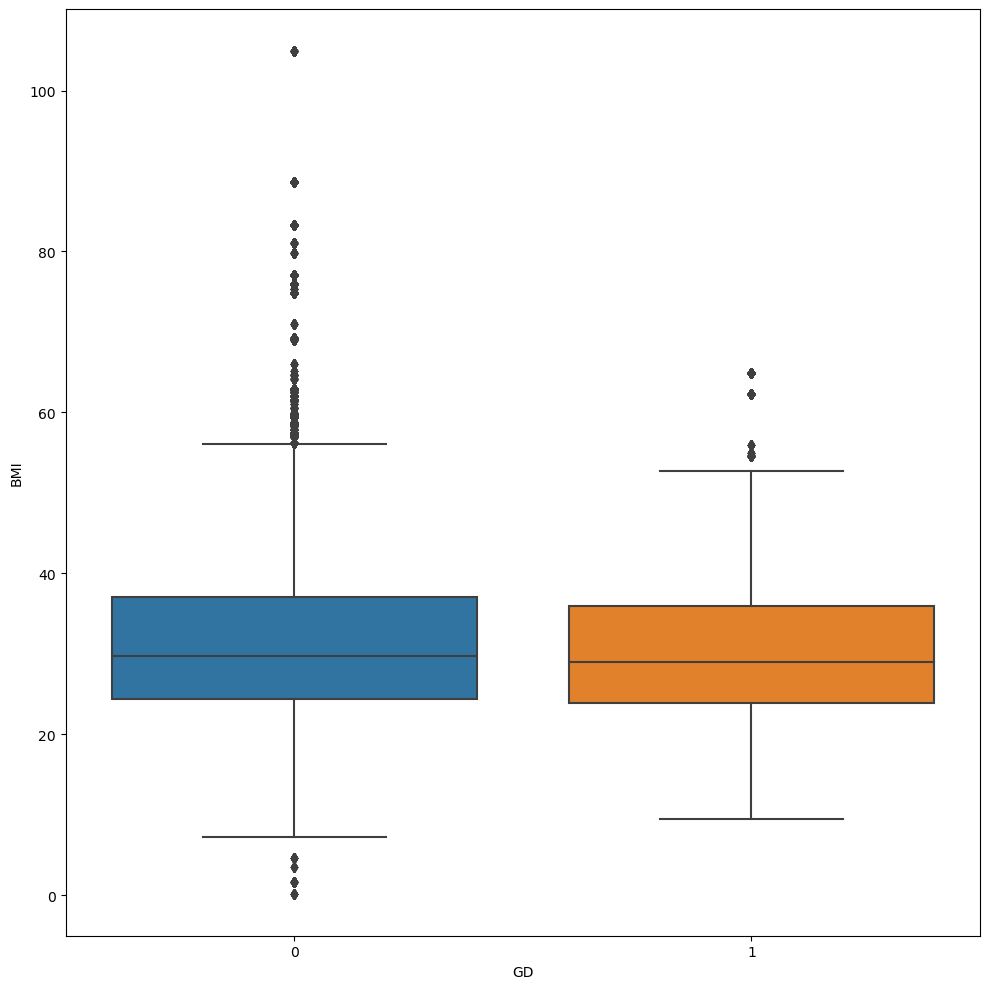

In [30]:
fig = plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='GD', y='BMI', data=final_df)
fig.tight_layout()
plt.show()


In [ ]:
# Fill in missing values. Try multiple imputation method.

In [31]:
final_df.isnull().sum()


GD                         0
diabete_history            0
blood                      0
circulatory                0
congenital                 0
digestive                  0
endocrine                  0
genitourinary              0
infectious                 0
injury                     0
mental                     0
misc                       0
muscular                   0
neoplasms                  0
nervous                    0
pregnancy                  0
prenatal                   0
respiratory                0
skin                       0
BMI                      233
Systolic_BP                0
Diastolic_BP               0
Glucose                    0
Hemoglobin A1c         98325
HDL                   115774
LDL                   123418
Creatinine                 0
Triglycerides          91830
Urea Nitrogen              0
RACE_ASIAN                 0
RACE_BLACK                 0
RACE_HISPANIC              0
RACE_OTHER/UNKNOWN         0
RACE_WHITE                 0
AGE_MIDDLE_ADU

In [32]:
from fancyimpute import IterativeImputer
import pandas as pd



In [33]:
# 将 Hemoglobin A1c 这一列单独拆分出来，构建一个新的数据集
impute_cols = ["Hemoglobin A1c"]
impute_df = final_df[impute_cols].copy()

# 使用 IterativeImputer 进行插补操作
imputer = IterativeImputer()
imputed_cols = imputer.fit_transform(impute_df)




In [34]:
imputed_cols_df = pd.DataFrame(imputed_cols, columns=impute_cols, index=impute_df.index)
imputed_cols_df.isnull().sum()


Hemoglobin A1c    0
dtype: int64

In [35]:
imputed_cols_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447254 entries, 61 to 984013
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Hemoglobin A1c  447254 non-null  float64
dtypes: float64(1)
memory usage: 6.8 MB


In [36]:
# 将插补后的新列替换回原来的数据集中
final_df["Hemoglobin A1c"] = imputed_cols

# 检查是否替换成功
print(final_df.isnull().sum())


GD                         0
diabete_history            0
blood                      0
circulatory                0
congenital                 0
digestive                  0
endocrine                  0
genitourinary              0
infectious                 0
injury                     0
mental                     0
misc                       0
muscular                   0
neoplasms                  0
nervous                    0
pregnancy                  0
prenatal                   0
respiratory                0
skin                       0
BMI                      233
Systolic_BP                0
Diastolic_BP               0
Glucose                    0
Hemoglobin A1c             0
HDL                   115774
LDL                   123418
Creatinine                 0
Triglycerides          91830
Urea Nitrogen              0
RACE_ASIAN                 0
RACE_BLACK                 0
RACE_HISPANIC              0
RACE_OTHER/UNKNOWN         0
RACE_WHITE                 0
AGE_MIDDLE_ADU

Use the same method to fill in missing values of BMI, HDL, LDL, and Triglycerides.

In [37]:
impute_bmi = ["BMI"]
impute_bmi_df = final_df[impute_bmi].copy()

# 使用 IterativeImputer 进行插补操作
imputer = IterativeImputer()
imputed_bmi = imputer.fit_transform(impute_bmi_df)


In [38]:
imputed_BMI_df = pd.DataFrame(imputed_bmi, columns=impute_bmi, index=impute_bmi_df.index)
imputed_BMI_df.isnull().sum()

BMI    0
dtype: int64

In [39]:
imputed_BMI_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447254 entries, 61 to 984013
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   BMI     447254 non-null  float64
dtypes: float64(1)
memory usage: 6.8 MB


In [40]:
# 将插补后的新列替换回原来的数据集中
final_df["BMI"] = imputed_bmi

# 检查是否替换成功
print(final_df.isnull().sum())


GD                         0
diabete_history            0
blood                      0
circulatory                0
congenital                 0
digestive                  0
endocrine                  0
genitourinary              0
infectious                 0
injury                     0
mental                     0
misc                       0
muscular                   0
neoplasms                  0
nervous                    0
pregnancy                  0
prenatal                   0
respiratory                0
skin                       0
BMI                        0
Systolic_BP                0
Diastolic_BP               0
Glucose                    0
Hemoglobin A1c             0
HDL                   115774
LDL                   123418
Creatinine                 0
Triglycerides          91830
Urea Nitrogen              0
RACE_ASIAN                 0
RACE_BLACK                 0
RACE_HISPANIC              0
RACE_OTHER/UNKNOWN         0
RACE_WHITE                 0
AGE_MIDDLE_ADU

In [41]:
impute_hdl = ["HDL"]
impute_hdl_df = final_df[impute_hdl].copy()

# 使用 IterativeImputer 进行插补操作
imputer = IterativeImputer()
imputed_hdl = imputer.fit_transform(impute_hdl_df)
imputed_HDL_df = pd.DataFrame(imputed_hdl, columns=impute_hdl, index=impute_hdl_df.index)
imputed_HDL_df.isnull().sum()

HDL    0
dtype: int64

In [42]:
final_df["HDL"] = imputed_hdl

# 检查是否替换成功
print(final_df.isnull().sum())

GD                         0
diabete_history            0
blood                      0
circulatory                0
congenital                 0
digestive                  0
endocrine                  0
genitourinary              0
infectious                 0
injury                     0
mental                     0
misc                       0
muscular                   0
neoplasms                  0
nervous                    0
pregnancy                  0
prenatal                   0
respiratory                0
skin                       0
BMI                        0
Systolic_BP                0
Diastolic_BP               0
Glucose                    0
Hemoglobin A1c             0
HDL                        0
LDL                   123418
Creatinine                 0
Triglycerides          91830
Urea Nitrogen              0
RACE_ASIAN                 0
RACE_BLACK                 0
RACE_HISPANIC              0
RACE_OTHER/UNKNOWN         0
RACE_WHITE                 0
AGE_MIDDLE_ADU

In [43]:
impute_ldl = ["LDL"]
impute_ldl_df = final_df[impute_ldl].copy()

# 使用 IterativeImputer 进行插补操作
imputer = IterativeImputer()
imputed_ldl = imputer.fit_transform(impute_ldl_df)
imputed_LDL_df = pd.DataFrame(imputed_ldl, columns=impute_ldl, index=impute_ldl_df.index)
imputed_LDL_df.isnull().sum()

LDL    0
dtype: int64

In [44]:
final_df["LDL"] = imputed_ldl

# 检查是否替换成功
print(final_df.isnull().sum())

GD                        0
diabete_history           0
blood                     0
circulatory               0
congenital                0
digestive                 0
endocrine                 0
genitourinary             0
infectious                0
injury                    0
mental                    0
misc                      0
muscular                  0
neoplasms                 0
nervous                   0
pregnancy                 0
prenatal                  0
respiratory               0
skin                      0
BMI                       0
Systolic_BP               0
Diastolic_BP              0
Glucose                   0
Hemoglobin A1c            0
HDL                       0
LDL                       0
Creatinine                0
Triglycerides         91830
Urea Nitrogen             0
RACE_ASIAN                0
RACE_BLACK                0
RACE_HISPANIC             0
RACE_OTHER/UNKNOWN        0
RACE_WHITE                0
AGE_MIDDLE_ADULT          0
AGE_OLD_ADULT       

In [45]:
impute_tri = ["Triglycerides"]
impute_tri_df = final_df[impute_tri].copy()

# 使用 IterativeImputer 进行插补操作
imputer = IterativeImputer()
imputed_tri = imputer.fit_transform(impute_tri_df)
imputed_TRI_df = pd.DataFrame(imputed_tri, columns=impute_tri, index=impute_tri_df.index)
imputed_TRI_df.isnull().sum()

Triglycerides    0
dtype: int64

In [46]:
final_df["Triglycerides"] = imputed_tri

# 检查是否替换成功
print(final_df.isnull().sum())

GD                    0
diabete_history       0
blood                 0
circulatory           0
congenital            0
digestive             0
endocrine             0
genitourinary         0
infectious            0
injury                0
mental                0
misc                  0
muscular              0
neoplasms             0
nervous               0
pregnancy             0
prenatal              0
respiratory           0
skin                  0
BMI                   0
Systolic_BP           0
Diastolic_BP          0
Glucose               0
Hemoglobin A1c        0
HDL                   0
LDL                   0
Creatinine            0
Triglycerides         0
Urea Nitrogen         0
RACE_ASIAN            0
RACE_BLACK            0
RACE_HISPANIC         0
RACE_OTHER/UNKNOWN    0
RACE_WHITE            0
AGE_MIDDLE_ADULT      0
AGE_OLD_ADULT         0
AGE_SENIOR            0
AGE_YOUNG_ADULT       0
dtype: int64


In [47]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447254 entries, 61 to 984013
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   GD                  447254 non-null  int64  
 1   diabete_history     447254 non-null  int64  
 2   blood               447254 non-null  int64  
 3   circulatory         447254 non-null  int64  
 4   congenital          447254 non-null  int64  
 5   digestive           447254 non-null  int64  
 6   endocrine           447254 non-null  int64  
 7   genitourinary       447254 non-null  int64  
 8   infectious          447254 non-null  int64  
 9   injury              447254 non-null  int64  
 10  mental              447254 non-null  int64  
 11  misc                447254 non-null  int64  
 12  muscular            447254 non-null  int64  
 13  neoplasms           447254 non-null  int64  
 14  nervous             447254 non-null  int64  
 15  pregnancy           447254 non-nu

In [48]:

final_df.to_csv('final_df_no_insulin.csv', index=False)
